# Adaptive stopping in a Bandit problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from compare_agents import MultipleAgentsComparator, Two_AgentsComparator

from rlberry.agents.torch import DQNAgent, PPOAgent, A2CAgent
from rlberry.agents import RSUCBVIAgent
import pandas as pd

from rlberry.envs.bandits import BernoulliBandit
from rlberry.wrappers import WriterWrapper
from rlberry.agents.bandits import (
    IndexAgent,
    RandomizedAgent,
    makeBoundedIMEDIndex,
    makeBoundedMOSSIndex,
    makeBoundedNPTSIndex,
    makeBoundedUCBIndex,
)



We wish to reproduce the results in https://rlberry.readthedocs.io/en/latest/auto_examples/demo_bandits/plot_compare_index_bandits.html#sphx-glr-auto-examples-demo-bandits-plot-compare-index-bandits-py


## Problem setting

In [2]:
# Parameters of the problem
means = np.array([0.6, 0.6, 0.6, 0.9])  # means of the arms
A = len(means)
T = 2000  # Horizon
M = 10  # number of MC simu

# Construction of the experiment

env_ctor = BernoulliBandit
env_kwargs = {"p": means}


class UCBAgent(IndexAgent):
    name = "UCB"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedUCBIndex()
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )
        
class MOSSAgent(IndexAgent):
    name = "MOSS"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedMOSSIndex(T, A)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )


class IMEDAgent(IndexAgent):
    name = "IMED"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedIMEDIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )

class NPTSAgent(IndexAgent):
    name = "NPTS"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedNPTSIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )


Agents_class = [
    MOSSAgent,
    IMEDAgent,
    NPTSAgent,
    UCBAgent,
]

managers = [
    (Agent,
        dict(
        train_env=(env_ctor, env_kwargs),
        fit_budget=T,
        parallelization="process",
        mp_context="fork")
    )
    for Agent in Agents_class
]


## Adastop algorithm

In [3]:
# we want to be able to see a difference of 5 and the std is around 10
n = 10
K = 10
B=100000
alpha = 0.05

In [8]:

n_managers = len(managers)
print('With these parameters, we have a maximum of {} fits done for each agent'.format(n*K))
print('Number of comparisons is {}'.format(n_managers*(n_managers-1)/2))

With these parameters, we have a maximum of 100 fits done for each agent
Number of comparisons is 6.0


let us now compare all the different algorithm

In [9]:
from rlberry.utils.logging import set_level
set_level('ERROR')

In [10]:
class Comparator(MultipleAgentsComparator):
    def __init__(self, **kwargs):
        MultipleAgentsComparator.__init__(self, **kwargs)
        
    def _get_evals(self, manager):
        """
        Compute the cumulative reward.
        """
        eval_values = []
        for idx in  manager.get_writer_data():
            df = manager.get_writer_data()[idx]
            eval_values.append(-np.sum(np.max(means)-df.loc[df['tag']=='reward', 'value']))
        return eval_values

In [11]:
comparator  = Comparator(n=n, K=K, B=B, alpha=alpha, n_evaluations = 100)

comparator.compare(managers)

print(comparator.decisions,
      comparator.comparisons,
      comparator.rejected_decision)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
['reject' 'reject' 'reject' 'accept' 'reject' 'reject'] [[0 1]
 [0 2]
 [0 3]
 [1 2]
 [1 3]
 [2 3]] [array([1, 3]), array([0, 1]), array([2, 3]), array([0, 3]), array([0, 2])]


We reject the comparisons (1,3), (0,1), (0,2) and (0,3). Let us check graphically that this makes sense

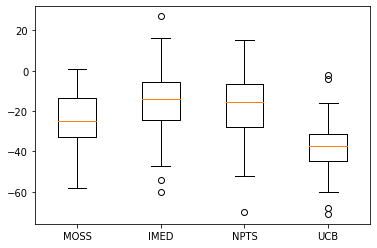

In [12]:
plt.boxplot(comparator.eval_values, labels=['MOSS', 'IMED', 'NPTS', 'UCB'])
plt.show()

In [13]:
print(comparator.mean_eval_values)

[-25.342857142855195, -15.189999999999452, -17.149999999999284, -37.99999999999787]


The rejected comparisons are the comparisons with the last algo (UCB) and MOSS.

In [14]:
print(comparator.n_iters)

[70, 100, 100, 50]
